## 1. Albumentations
- https://github.com/albumentations-team/albumentations
- 이미지를 쉽게 augmentation 해주는 파이썬 라이브러리
- 다양한 영상변환 알고리즘을 제공하고 있고, 처리속도도 매우 빨라 딥러닝 전처리용으로 많이 사용

In [1]:
!pip install albumentations

Defaulting to user installation because normal site-packages is not writeable
     -------------------------------------- 102.4/102.4 KB 5.8 MB/s eta 0:00:00
     -------------------------------------- 153.2/153.2 KB 8.9 MB/s eta 0:00:00
     --------------------------------------- 12.1/12.1 MB 25.2 MB/s eta 0:00:00
     --------------------------------------- 35.5/35.5 MB 25.2 MB/s eta 0:00:00
     ---------------------------------------- 3.4/3.4 MB 36.0 MB/s eta 0:00:00
     ---------------------------------------- 4.2/4.2 MB 33.2 MB/s eta 0:00:00
     ---------------------------------------- 1.9/1.9 MB 24.6 MB/s eta 0:00:00
     ------------------------------------- 178.9/178.9 KB 10.5 MB/s eta 0:00:00


  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
You should consider upgrading via the 'c:\program files\python37\python.exe -m pip install --upgrade pip' command.


In [13]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import activations

import tensorflow as tf
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [14]:
import albumentations as A

In [15]:
class Augmentation:
    def __init__(self, size, mode='train'):
        if mode == 'train':
            self.transform = A.Compose([
                # 수평
                A.HorizontalFlip(p=0.5),
                A.ShiftScaleRotate(
                    p=0.5,
                    shift_limit=0.05,
                    scale_limit=0.05,
                    rotate_limit=15
                ),
                # 구멍을 최대 8개 Dropout
                A.CoarseDropout(
                    p=0.5,
                    max_holes=8,
                    max_height=int(0.1 * size),
                    max_width=int(0.1 * size)
                ),
                A.RandomBrightnessContrast(p=0.2)
            ])
        
    # **kwargs : 매개변수 개수 상관없이 받아서 리스트 처리
    def __call__(self, **kwargs):
        if self.transform :
            augmented = self.transform(**kwargs)
            img = augmented['image']
            return img
            
        

In [19]:
import math

class DataGenerator(keras.utils.Sequence):
    def __init__(self, batch_size, csv_path, fold, image_size, mode='train',  shuffle=True):
        self.batch_size = batch_size
        self.fold = fold
        self.image_size = image_size
        self.mode = mode
        self.shuffle = shuffle
        
        self.df = pd.read_csv(csv_path)
        
        if self.mode == 'train':
            self.df = self.df[self.df['fold'] != self.fold]
        elif self.mode == 'val':
            self.df = self.df[self.df['fold'] == self.fold]
            
            
        # https://github.com/tensorflow/models/issues/3134
        # 파일 이슈 -> 삭제
        # Egyptian_Mau_14, 139, 145, 156, 167, 177, 186, 191;
        # Abyssinian_5, 34. 121, 116
        
        invalid_filenames = [
            'Egyptian_Mau_14',
            'Egyptian_Mau_139',
            'Egyptian_Mau_145',
            'Egyptian_Mau_156',
            'Egyptian_Mau_167',
            'Egyptian_Mau_177',
            'Egyptian_Mau_186',
            'Egyptian_Mau_191',
            'Abyssinian_5',
            'Abyssinian_34',
            'Abyssinian_121',
            'Abyssinian_116'
        ]
        
        # isin : 포함을 의미
        self.df = self.df[~self.df['file_name'].isin(invalid_filenames)]    # invalid_filenames을 file_name으로 찾아서 그것을 제외한 데이터프레임 생성
        self.transform = Augmentation(image_size, mode)
        
        self.on_epoch_end()
        
    # sample() : 전체 row에서 몇 %의 데이터를 return 할 것인지 설정
    # frac : 데이터프레임으로 부터 특정 비율로 무작위 표본 추출을 하고 싶으면 0~1 사이의 부동소수점 입력
    # reset_index() : drop=True 옵션을 설정하면 인덱스 열을 보통의 자료열로 설정하는 것이 아니라 버림
    # 여기서 인데스 열이란 데이터프레임 맨 앞 열에 생성되는 인덱스 열을 말함
    def on_epoch_end(self):
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)
            
    # len() 함수를 재구현  (공유파일 첫 달에서 스페셜매소드 파일에서 다뤘음)
    def __len__(self):
        return math.ceil(len(self.df) / self.batch_size)
    
    # 배열을 쓸 때 자동으로 불러지는 것
    def __getitem__(self, idx):
        start = idx * self.batch_size
        end = (idx + 1) * self.batch_size
        data = self.df.iloc[start:end]
        batch_x, batch_y = self.get_data(data)
        return np.array(batch_x), np.array(batch_y)
        
    def get_data(self, data):
        batch_x = []
        batch_y = []
        
        # iterrows
        # 데이터프레임에서 row의 개수만큼 반복
        # 튜플로 리턴[index, 행정보(Series)]
        for _, r in data.iterrows():             
            file_name = r['file_name']
            image = cv2.imread(f'D:/data_ai/5_AI/images/{file_name}.jpg')
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = cv2.resize(image, (self.image_size, self.image_size))
            
            if self.mode == 'train':
                image = image.astype('uint8')
                image = self.transform(image=image)
                
            image = image.astype('float32')
            image = image / 255    # 정규화
            
            label = int(r['species']) - 1    # 밑에서 class_name 인덱스와 맞추기위해 (-1)해줌
            
            batch_x.append(image)
            batch_y.append(label)
            
        return batch_x, batch_y

In [20]:
csv_path = 'D:/data_ai/5_AI/kfolds.csv'

train_generator = DataGenerator(
    # 옵션
    batch_size = 128, 
    csv_path = csv_path, 
    fold = 1, 
    image_size = 256, 
    mode = 'train', 
    shuffle = True
)

valid_generator = DataGenerator(
    # 옵션
    batch_size = 128, 
    csv_path = csv_path, 
    fold = 1, 
    image_size = 256, 
    mode = 'val', 
    shuffle = True
)

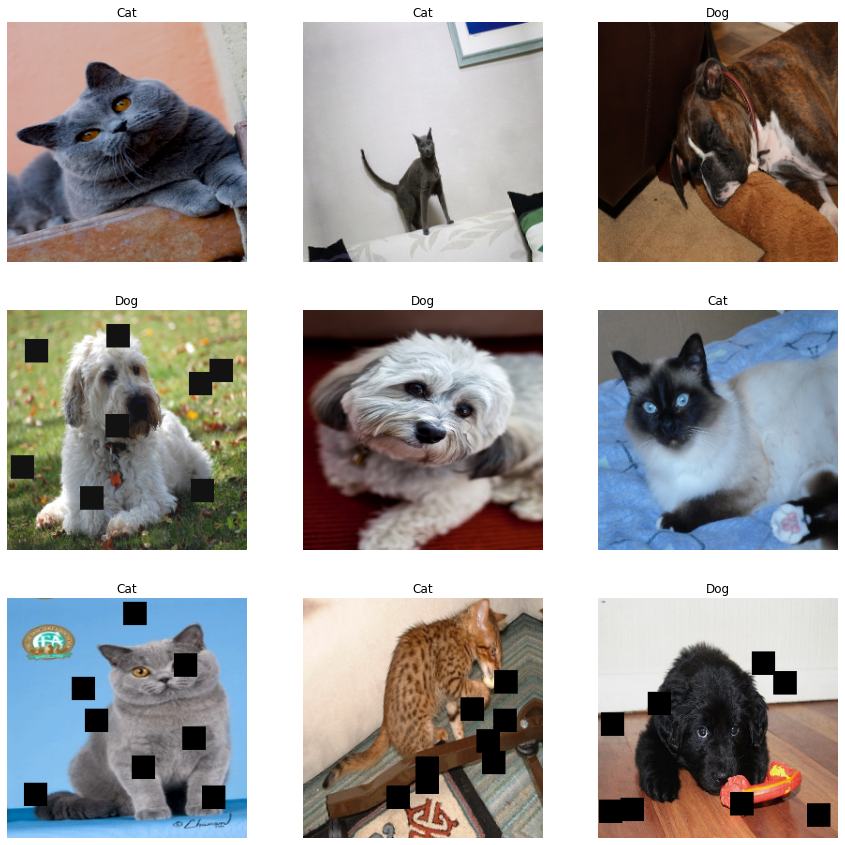

In [23]:
class_name = ['Cat', 'Dog']

for batch in train_generator:
    X, y = batch
    plt.figure(figsize=(15, 15))
    
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(X[i])
        plt.title(class_name[y[i]])
        plt.axis('off')
    break

In [24]:
def get_sequential_model(input_shape):
    model = keras.Sequential(
        [
            layers.Input(input_shape),
            
            # 1st
            layers.Conv2D(64, 3, strides=1, activation='relu', padding='same'),    # 64 : 필터 수(출력), 3 : 3x3 필터 크기 => 각 필터의 가중치는 다름
            layers.Conv2D(64, 3, strides=1, activation='relu', padding='same'),
            layers.MaxPool2D(),
            layers.BatchNormalization(),    # 배치별 특징 값을 정규화(relu로 인한 다양한 값 생성(local optimal)) => 학습 속도 증가
            layers.Dropout(0.5),
            
            # 2nd
            layers.Conv2D(128, 3, strides=1, activation='relu', padding='same'),    # 128 : 필터 수(출력), 3 : 3x3 필터 크기 => 각 필터의 가중치는 다름
            layers.Conv2D(128, 3, strides=1, activation='relu', padding='same'),
            layers.MaxPool2D(),
            layers.BatchNormalization(),    # 배치별 특징 값을 정규화(relu로 인한 다양한 값 생성(local optimal)) => 학습 속도 증가
            layers.Dropout(0.3),
            
            # FC
            layers.GlobalMaxPool2D(),
            layers.Dense(128, activation='relu'),    # 2nd에서 출력이 128개
            layers.Dense(1, activation='sigmoid')    # 마지막 결과 : 맞는지 여부(2진 논리)
        ]
    )
    
    return model

In [25]:
input_shape = (256, 256, 3)
model = get_sequential_model(input_shape)

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics='accuracy'
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 256, 256, 64)      36928     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 64)     0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 128, 128, 64)     256       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 128, 128, 64)      0         
                                                                 
 conv2d_2 (Conv2D)           (None, 128, 128, 128)     7

In [ ]:
history = model.fit(
    train_generator,
    validation_data = valid_generator,
    epochs=10,
    verbose=1
)

Epoch 1/10


```
Epoch 1/10
 2/46 [>.............................] - ETA: 11s - loss: 7.0101 - accuracy: 0.4922WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.1469s vs `on_train_batch_end` time: 0.3603s). Check your callbacks.
46/46 [==============================] - ETA: 0s - loss: 1.0686 - accuracy: 0.6473
Epoch 00001: val_loss improved from inf to 0.65360, saving model to 01-0.65.hdf5
46/46 [==============================] - 59s 1s/step - loss: 1.0686 - accuracy: 0.6473 - val_loss: 0.6536 - val_accuracy: 0.6780
Epoch 2/10
46/46 [==============================] - ETA: 0s - loss: 0.6110 - accuracy: 0.6832
Epoch 00002: val_loss improved from 0.65360 to 0.64777, saving model to 02-0.65.hdf5
46/46 [==============================] - 56s 1s/step - loss: 0.6110 - accuracy: 0.6832 - val_loss: 0.6478 - val_accuracy: 0.6814
21:16:49	 발신자 IT 강남 E_Class : Epoch 3/10
46/46 [==============================] - ETA: 0s - loss: 0.6061 - accuracy: 0.6760
Epoch 00003: val_loss did not improve from 0.64777
46/46 [==============================] - 56s 1s/step - loss: 0.6061 - accuracy: 0.6760 - val_loss: 0.6572 - val_accuracy: 0.6794
Epoch 4/10
46/46 [==============================] - ETA: 0s - loss: 0.5954 - accuracy: 0.6914
Epoch 00004: val_loss did not improve from 0.64777
46/46 [==============================] - 56s 1s/step - loss: 0.5954 - accuracy: 0.6914 - val_loss: 0.6731 - val_accuracy: 0.6726
Epoch 5/10
46/46 [==============================] - ETA: 0s - loss: 0.6125 - accuracy: 0.6835
Epoch 00005: val_loss did not improve from 0.64777
46/46 [==============================] - 56s 1s/step - loss: 0.6125 - accuracy: 0.6835 - val_loss: 0.6696 - val_accuracy: 0.6767
Epoch 00005: early stopping

```

val_loss가 그대로이기 때문에 early stopping으로 끝맞침